In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors
from tensorflow.keras import layers
from tensorflow.keras.losses import categorical_crossentropy
from keras.layers import Dense, Dropout, LSTM

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/augusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/augusto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [2]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'])

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])

print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  Estou contente com a compra entrega rápida o ú...
1                    4  Por apenas R$1994.20,eu consegui comprar esse ...
2                    4  SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3                    4  MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4                    5  A entrega foi no prazo, as americanas estão de...
...                ...                                                ...
132368               5  Vale muito, estou usando no controle do Xbox e...
132369               5  Prático e barato, super indico o produto para ...
132370               4  Chegou antes do prazo previsto e corresponde a...
132371               1  Material fraco, poderia ser melhor. Ficou deve...
132372               1  Comprei esse produto, quando chegou estava com...

[132373 rows x 2 columns]>


In [3]:
# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [4]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [5]:
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  contente compra entrega rapida unico problema ...
1                    4        apenas consegui comprar lindo copo acrilico
2                    4  supera agilidade praticidade outras panelas el...
3                    4          filho amou parece verdade tantos detalhes
4                    5  entrega prazo americanas estao parabens smart ...
...                ...                                                ...
132368               5  vale usando controle xbox durou semana carga p...
132369               5  pratico barato super indico produto corre dia ...
132370               4    chegou antes prazo previsto corresponde anuncio
132371               1  material fraco poderia ser melhor ficou devend...
132372               1  comprei produto chegou avaria devolvi ja vai f...

[132373 rows x 2 columns]>


In [6]:
b2wCorpus.overall_rating .value_counts().sort_index()

1    27369
2     8389
3    16315
4    32345
5    47955
Name: overall_rating, dtype: int64

In [7]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    5  entrega super antes prazo cafeteira super bem ...
1                    4  conforme expectativas boa relacao preco qualidade
2                    1  descricao produto diz original apple nao passa...
3                    1  cambio roda traseira rompeu condicoes normais ...
4                    5  recomendo chegou antes prazo produto otima qua...
...                ...                                                ...
132368               4  imagem excelente manuseio extremamente simples...
132369               1  recebi tamanho menor anunciado produto bom esp...
132370               1  comprei kit total entregaram capa maior havia ...
132371               5  produto recebido mim comecei carregar primeira...
132372               5  comprei site americanas nao nenhum problema en...

[132373 rows x 2 columns]>


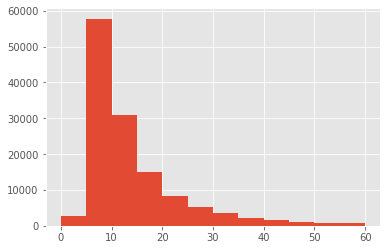

130344


In [8]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=60 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.show()
print(len(Words))

In [9]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '0'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [10]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [11]:
b2wCorpus.shape

(132373, 3)

In [12]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 10].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > 50].index)

In [13]:
b2wCorpus['overall_rating'] = b2wCorpus.overall_rating.apply(lambda x: x - 1)

In [14]:
b2wCorpus.shape

(68406, 3)

In [15]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [16]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,4,"[2499, 2789, 131, 566, 47785, 2789, 70, 39547,...",13
1,0,"[0, 902, 222, 1100, 3917, 7804, 795, 902, 4614...",14
2,0,"[54213, 5635, 7856, 13383, 0, 4521, 635, 2354,...",37
3,4,"[6376, 902, 7705, 2499, 12783, 1643, 789, 4587...",11
4,4,"[18495, 168, 548, 7550, 1853, 18495, 22522, 98...",10


In [17]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [18]:
#b2wCorpus.review_text.str.rjust(width=50, fillchar='0')
#np.reshape(y_train,(-1))

b2wCorpus.review_text = keras.preprocessing.sequence.pad_sequences(b2wCorpus.apply(lambda row: np.reshape(row.review_text,(-1)), axis=1), maxlen=50, padding='post').tolist()

In [19]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,4,"[2499, 2789, 131, 566, 47785, 2789, 70, 39547,...",13
1,0,"[0, 902, 222, 1100, 3917, 7804, 795, 902, 4614...",14
2,0,"[54213, 5635, 7856, 13383, 0, 4521, 635, 2354,...",37
3,4,"[6376, 902, 7705, 2499, 12783, 1643, 789, 4587...",11
4,4,"[18495, 168, 548, 7550, 1853, 18495, 22522, 98...",10


In [20]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [21]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [22]:
b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

,overall_rating,review_text,ord
27996,0,"[36387, 12783, 327, 273, 4584, 6045, 5622, 134...",50
53190,0,"[7256, 775, 3385, 1027, 930, 10185, 14762, 162...",50
35551,2,"[44608, 12709, 5137, 17299, 784, 106, 4197, 51...",50
36705,2,"[266, 1858, 23933, 46237, 12689, 35629, 5193, ...",50
38205,0,"[9735, 760, 965, 5301, 5117, 1118, 2566, 27091...",50


In [23]:
#b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
35006               4  [7256, 902, 131, 566, 110, 232, 292, 727, 784,...   15
12039               4  [902, 2104, 16299, 0, 9255, 199745, 484, 23941...   38
1205                3  [226, 12574, 7804, 26649, 40375, 3377, 167, 28...   15
52717               2  [0, 1664, 86, 86, 1101, 5529, 86, 9686, 785, 1...   46
55836               4  [902, 363, 532, 161274, 978, 54465, 4347, 250,...   18
...               ...                                                ...  ...
33447               0  [5437, 3222, 7550, 1664, 10977, 969, 0, 4644, ...   32
41535               1  [323, 11264, 7804, 23933, 0, 532, 45542, 1533,...   36
54315               2  [10883, 70, 3021, 36514, 12783, 246, 0, 1977, ...   20
34120               4  [9735, 0, 3711, 4703, 128186, 12783, 915, 8366...   11
3902                1  [0, 12871, 226, 0, 10492, 7804, 958, 7958, 211...   39

[6840 rows x 3 columns]>

In [24]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
30794               0  [9735, 182416, 86, 0, 976, 0, 7804, 52469, 245...   50
27353               0  [9735, 1627, 902, 7256, 141, 2420, 902, 428, 8...   50
41025               4  [3615, 70, 21144, 428, 70, 131, 566, 902, 1909...   50
30832               1  [58469, 1664, 221, 17382, 7804, 62, 867, 0, 0,...   50
49703               3  [508, 30093, 20883, 8176, 1104, 29462, 1126, 2...   50
...               ...                                                ...  ...
60308               4  [2532, 11192, 126294, 7804, 16552, 5617, 2113,...   10
9088                4  [716, 821, 1108, 86954, 9095, 23933, 1494, 996...   10
61106               3  [101071, 17390, 428, 131, 578, 1761, 254, 0, 8...   10
16350               0  [90008, 62, 7804, 7256, 902, 12783, 21513, 470...   10
34457               3  [1316, 113, 0, 21469, 0, 10689, 7551, 3136, 85...   10

[17103 rows x 3 columns]>

In [25]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [26]:
# Treino, Validação e teste
RANDOM_SEED = 42
x_train =  [ emb for emb in b2wCorpusTrain.review_text]
y_train =   b2wCorpusTrain.overall_rating
x_val = [ emb for emb in b2wCorpusValidate.review_text ]
y_val = b2wCorpusValidate.overall_rating
x_train = np.asarray(x_train)
x_val =np.asarray(x_val)

np.random.seed(RANDOM_SEED)
model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')
emb = model.get_keras_embedding()
emb.trainable = True

In [30]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
SEQUENCE_MAXLEN = 50
model = keras.Sequential()
model.add(layers.Input(shape=(SEQUENCE_MAXLEN, )))
model.add(emb)

model.add(keras.layers.LSTM(32, dropout=0.5))
#model.add(Dropout(0.50))
model.add(keras.layers.Dense(5, activation='softmax'))
#opt = tf.keras.optimizers.SGD(learning_rate=.1, momentum=.5)
#opt = tf.keras.optimizers.Adamax(learning_rate=0.01, beta_1=.9, beta_2=.9, epsilon=1e-07, name="Adamax")
#model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc', 'mae'])
opt="adam"
model.compile(optimizer=opt,loss=sparse_categorical_crossentropy, metrics=["accuracy"])
history = model.fit(
    x= x_train, y=y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
695/695 [==============================] - 68s 97ms/step - loss: 0.9897 - accuracy: 0.5850 - val_loss: 1.0126 - val_accuracy: 0.5972
Epoch 2/50
695/695 [==============================] - 70s 100ms/step - loss: 0.8125 - accuracy: 0.6753 - val_loss: 1.0194 - val_accuracy: 0.5901
Epoch 3/50
695/695 [==============================] - 72s 103ms/step - loss: 0.7854 - accuracy: 0.6902 - val_loss: 1.0202 - val_accuracy: 0.6001
Epoch 4/50
583/695 [========================>.....] - ETA: 11s - loss: 0.7559 - accuracy: 0.7008

KeyboardInterrupt: 

In [ ]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();